In [1]:
import fitsio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pixell

import sys
sys.path.append('../../ThumbStack')

from cmb import StageIVCMB

import flat_map
from flat_map import *

import catalog
from catalog import *

import universe
from universe import *

import mass_conversion
from mass_conversion import *

In [352]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmasher as cm
plt.style.use('default.mplstyle')
%matplotlib inline

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [3]:
# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# number of pixels for the flat map, let's do 0.5' pixels
nX = int(sizeX*60.*2.)
nY = int(sizeY*60.*2.)

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
# reminder: l=100 ~ 1 degree
lMin = 30.; lMax = 6000.

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

# order: [[ra_min, dec_max], [ra_max, dec_min]]
box = np.array([[10., 210.], [20., 200.]]) * utils.degree
#box = np.array([[-5., 0.], [0., 5.]]) * utils.degree
resArcmin = 0.5 #1. #0.5  # 0.1   # map pixel size [arcmin]
shape,wcs = enmap.geometry(pos=box, res=resArcmin * utils.arcmin, proj='car')

# create a mask that keeps the whole area
boxMask = enmap.ones(shape, wcs=wcs)
pixsizemap = boxMask.pixsizemap()

89.23577240438216 22.34002769660062 8098.743248089867 8013.9237781951115 7809.790827383111 7729.167004512778


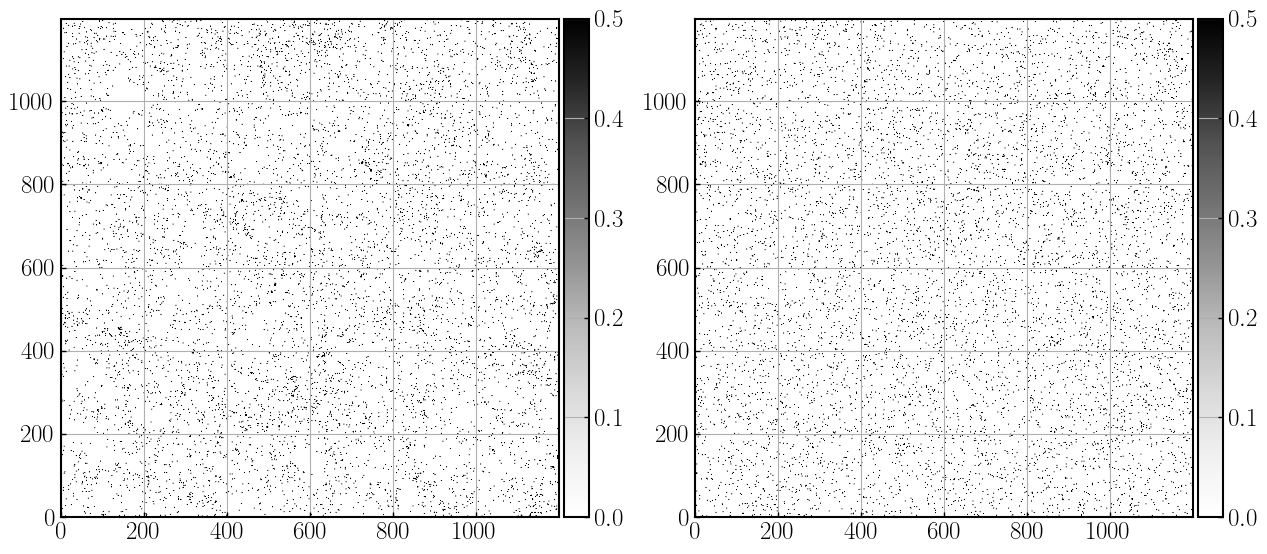

In [4]:
cmass_d = fitsio.read('../output/catalog/cmass_m_10x10_sig5/mock_count_dirac_car.fits')
rand_d = fitsio.read('../output/catalog/cmass_m_10x10_sig5_randradec/mock_count_dirac_car.fits')
fig, axs = plt.subplots(1,2, figsize=(15,7))
im0 = axs[0].imshow(cmass_d, cmap='Greys', origin='lower', vmin=0, vmax=0.5)
im1 = axs[1].imshow(rand_d, cmap='Greys', origin='lower', vmin=0, vmax=0.5)

cbar0 = colorbar(im0)
cbar1 = colorbar(im1)
print(np.max(cmass_d), np.max(rand_d), np.sum(cmass_d/4), np.sum(rand_d/4),
      np.sum(pixsizemap * cmass_d *(180. * 60./np.pi)**2),
      np.sum(pixsizemap * rand_d *(180. * 60./np.pi)**2))

0.41216536916425195 0.25705209227680714 7928.181432770566 7922.673038732933 7644.865914336587 7641.341212321351


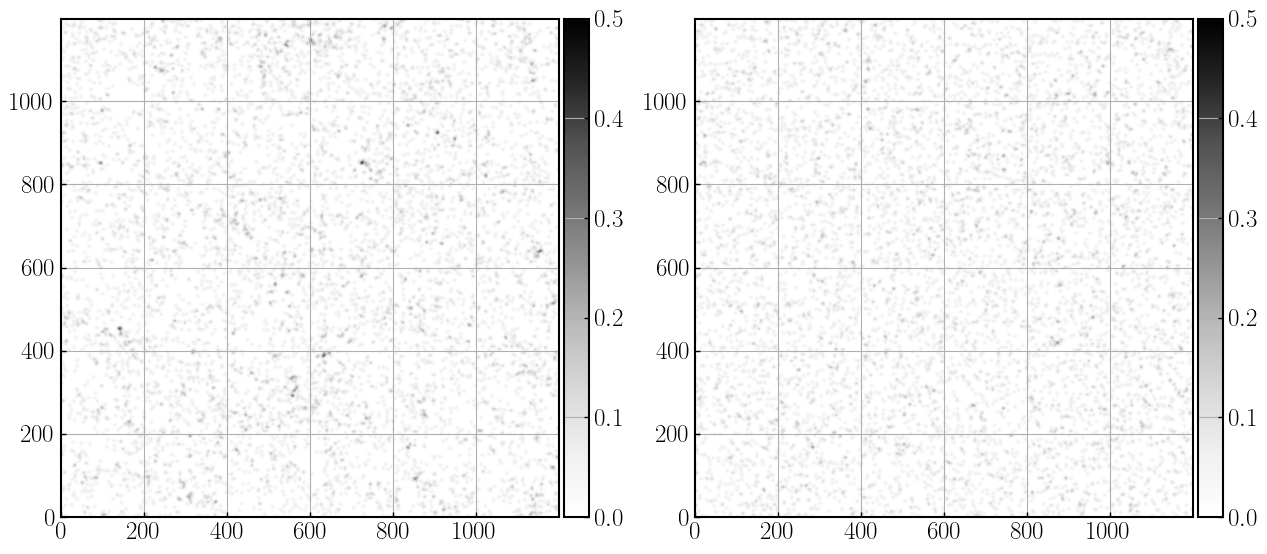

In [94]:
cmass = fitsio.read('../output/catalog/cmass_m_10x10_v2/cmass_m_10x10_v2_mock_count_gauss_car.fits')
rand = fitsio.read('../output/catalog/cmass_m_10x10_randradec_v2/cmass_m_10x10_randradec_v2_mock_count_gauss_car.fits')
fig, axs = plt.subplots(1,2, figsize=(15,7))
im0 = axs[0].imshow(cmass, cmap='Greys', origin='lower', vmin=0, vmax=0.5)
im1 = axs[1].imshow(rand, cmap='Greys', origin='lower', vmin=0, vmax=0.5)

cbar0 = colorbar(im0)
cbar1 = colorbar(im1)
print(np.max(cmass), np.max(rand), np.sum(cmass/4), np.sum(rand/4),
      np.sum(pixsizemap * cmass *(180. * 60./np.pi)**2),
      np.sum(pixsizemap * rand *(180. * 60./np.pi)**2))

Generating map


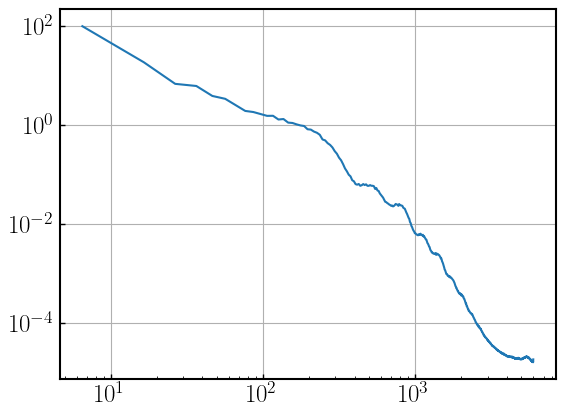

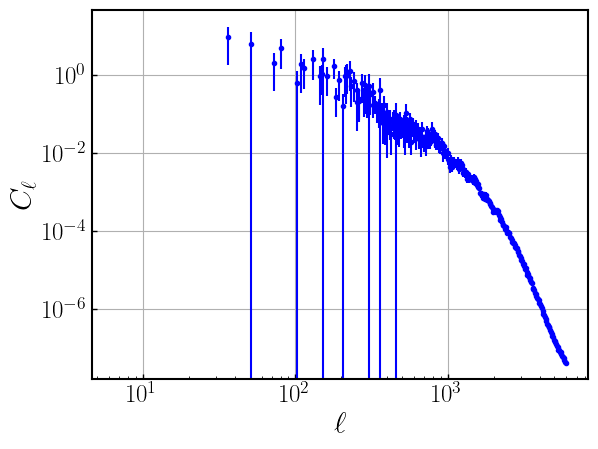

In [52]:
sys.path.append('../scripts/')
from make_noise_maps import make_cmb, gen_lensed_map, gen_map_from_data_powspec, gen_map_from_fn

datadir = '/home/theo/Documents/research/CMB/patchy_tau_sims/data/AdvACT_NILC_cls_fullRes_TT/'
ell = np.load(datadir+'ells.npy')
cl = np.load(datadir+'cl_tt.npy')
cmb = make_cmb()
plt.plot(ell, cl)
plt.loglog()
# actmap = gen_map_from_data_powspec(ell, cl, cmb, baseMap, name='actnilc', seed=100)
actmap = gen_map_from_fn(cmb.flensedTT, cmb, baseMap, name='actnilc', lMin=30, lMax=6000)
act_ell, act_cl, act_scl = actmap.powerSpectrum(lRange=ell, nBins=600, plot=True)

In [99]:
screenmap = actmap.copy()
screenmap.data = screenmap.data * (1-rand*5)

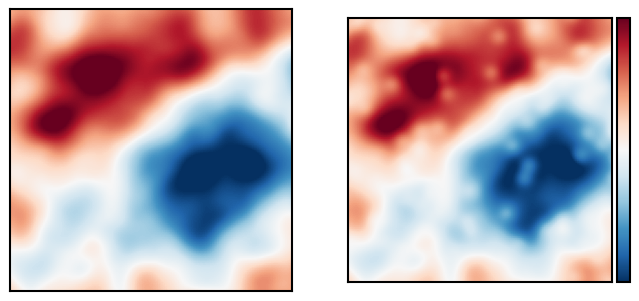

In [121]:
fig, axs = plt.subplots(1,2, figsize=(8,5))
bl_corner = 650
sq_size = 120
map1 = actmap.data[bl_corner:bl_corner+sq_size, bl_corner:bl_corner+sq_size]
map2 = screenmap.data[bl_corner:bl_corner+sq_size, bl_corner:bl_corner+sq_size]
for i, mmap in enumerate([map1, map2]):
    im = axs[i].imshow(mmap, cmap='RdBu_r', origin='lower', vmin=-200, vmax=200)

cbar = colorbar(im)
cbar.set_ticks([])
for ax in axs:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

In [354]:
def pretty_colorbar(mappable, pos='right', cbar_kw={}, cbax_kw=None):
    #FIXME: get to work on multiple rows
    import matplotlib.pyplot as plt
    import inspect
    last_axes = plt.gca()
    f = last_axes.figure
    left, bottom, width, height = last_axes.get_position().bounds
    pad = 0.02
    if pos == 'right':
        bounds = [left + width*(1 + pad), bottom, width*0.05, height]
    elif pos == 'bottom':
        bounds = [left, bottom - height*(1 + pad), width, height*0.05]
    cax = f.add_axes(bounds)
    cax.grid(False)
    cax.tick_params(axis='y', width=0.5)
    cbar = f.colorbar(mappable, cax=cax, **cbar_kw)
    if cbax_kw is not None:
        cax.set_ylabel(**cbax_kw)
    return cbar

In [355]:
def pretty_multi_im(im_list, ax_dict):
    # setup fig
    # ENH: make more general for vertical orientation (i.e. flip all subplot2grid values and place cbar on bottom)
    nplt = len(im_list)
    dx = ax_dict['ax_x']
    aspect_ratio = ax_dict['ax_aspect_ratio'] # y/x
    dy = aspect_ratio * dx * 2
    fig_x = dx*nplt + int(1.5*(nplt-1))
    print(fig_x, dy)
    fig = plt.figure(figsize=(fig_x, dy))

    axs = []
    for i, data in enumerate(im_list):
        if i > 0:
            ax = plt.subplot2grid((int(np.round(dy))*2 + 1, fig_x), (0,i*int(fig_x/nplt)), 
                                   rowspan=int(np.round(dy)), colspan=dx, sharey=first_ax)
        else:
            first_ax = plt.subplot2grid((int(np.round(dy))*2 + 1, fig_x), (0,i*int(fig_x/nplt)), 
                                   rowspan=int(np.round(dy)), colspan=dx)
            ax = first_ax
            ax.set(ylabel=ax_dict['ylabel'])
        ax.set(xlabel=ax_dict['xlabel'])
        # ax.set(xlim=(0,100), ylim=(0,100))
        ax.grid(ax_dict['grid'])
        im = ax.imshow(data, cmap=ax_dict['cmap'], origin='lower', vmin=ax_dict['vmin'], vmax=ax_dict['vmax'])
        axs.append(ax)

    pretty_colorbar(im, cbax_kw={'ylabel':ax_dict['cbar_label'], 'labelpad':0.1*mpl.rcParams['legend.fontsize']})

    # set up 2nd row 1d schematic plot
    last_axes = plt.gca()
    left, bottom, width, height = last_axes.get_position().bounds
    last_ax = plt.subplot2grid((int(np.round(dy))*2 + 1, fig_x), (int(dy)+2,0), 
                                   rowspan=int(np.round(dy)), colspan=fig_x-1)
    small_color = '#6a8b67'
    large_color = 'k'
    # s = ax.plot(x, small(x))
    # t = ax.plot(x, large(x) * ( 1 - small(x)), c='#ca8f5e', label=r'$\delta T_{\rm small}$')
    t = last_ax.plot(x, large(x) * ( 1 - small(x)), c=small_color, label=r'$\delta T_{\rm small}$')
    # lg = ax.plot(x, large(x), c='#574f78', label=r'$\delta T_{\rm large}$')
    lg = last_ax.plot(x, large(x), c=large_color, label=r'$\delta T_{\rm large}$')
    last_ax.grid(False)
    last_ax.axhline(0, ls=':', c='k', alpha=0.5)
    axs.append(last_ax)

    return fig, axs

9 8.0


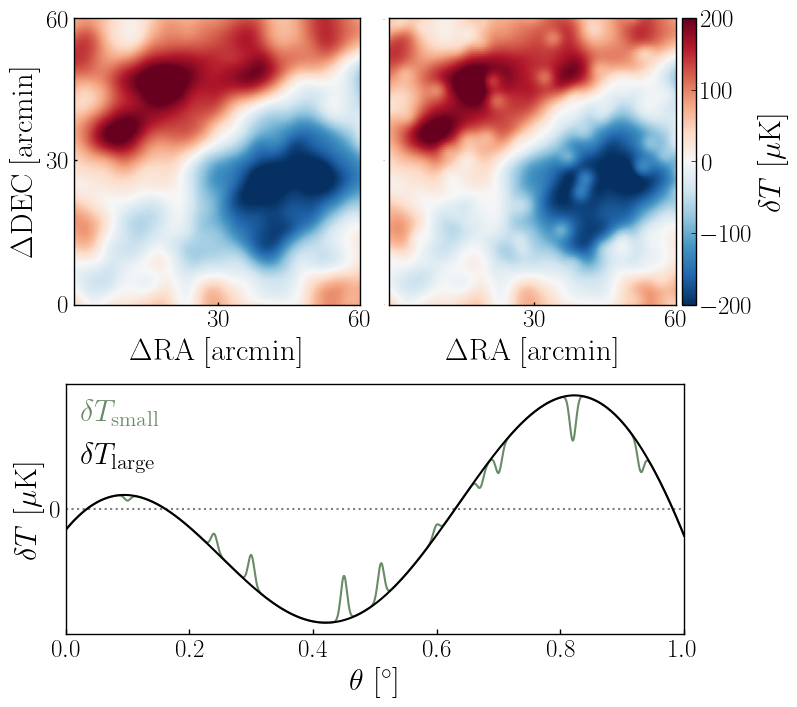

In [356]:
ax_dict={
    'xlabel': r'$\Delta$RA [arcmin]',
    'ylabel': r'$\Delta$DEC [arcmin]',
    'vmin': -200,
    'vmax': 200,
    'cbar_label': r'$\delta T$ [$\mu$K]',
    'ax_x': 4,
    'ax_aspect_ratio': 1.,
    'cmap': 'RdBu_r',
    'grid': False}
f, axs = pretty_multi_im((map1, map2), ax_dict)
for ax in axs[:-1]:
    ax.grid(False)
    ax.set_xticks([119], [60])
    ax.set_xticks([60], [30], minor=True)
    ax.set_yticks([0, 119], [0, 60])
    ax.set_yticks([60], [30], minor=True)
    ax.tick_params(which='major', axis='both', length=0)
    ax.tick_params(which='minor', axis='both', length=2, width=1)
axs[1].tick_params(axis='y', labelsize=0, length=0, which='both')
# axs[0].tick_params(axis='y', labelsize=0, which='both')
# axs[0].set_yticks([0, 119], [0, 60])
# axs[0].set_yticks([60], [30], minor=True)

axs[-1].set_yticks([0], [0])
axs[-1].tick_params(axis='y', length=0)
axs[-1].set(xlabel=r'$\theta~[^\circ]$', ylabel=r'$\delta T$ [$\mu$K]', xlim=[0, 1])
l = axs[-1].legend(frameon=False, framealpha=1., borderaxespad=0.1, handletextpad=0, handlelength=0, fontsize=22)
for lh in l.legend_handles:
    lh.set_visible(False)
for line, text in zip(l.get_lines(), l.get_texts()):
    text.set_color(line.get_color())

fn = '/home/theo/Documents/research/CMB/patchy_tau_sims/paper_figures/final/1d+2d_screening_schematic_v2'
plt.savefig(fn+'.pdf', dpi=72, bbox_inches='tight')
plt.savefig(fn+'.png', dpi=72, bbox_inches='tight')

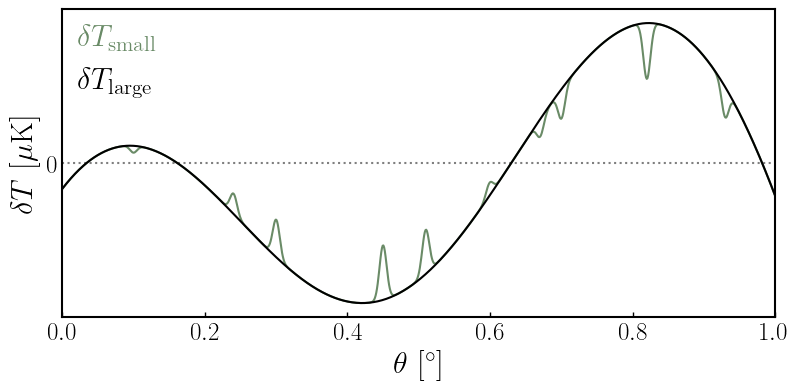

In [329]:
f, ax = plt.subplots(1,1, figsize=(9.2,4))
x = np.linspace(0, 1, 1000)
def large(x):
    return 100 * (2 * np.cos(7.*x) + 3 * np.sin(3.*x)) - 225

def gaussian(x, mu=0, sigma=1.):
    return np.sqrt(1/2/np.pi) * np.exp(-(x - mu)**2 / 2 / sigma**2)

def small(x, norm=1.):
    centroids = [0.1, 0.24, 0.3, 0.45, 0.51, 0.6, 0.67, 0.7, 0.82, 0.93]
    tot_fn = np.zeros_like(x)
    for c in centroids:
        tot_fn += norm * gaussian(x, mu=c, sigma=0.005)
    return tot_fn
small_color = '#6a8b67'
large_color = 'k'
# s = ax.plot(x, small(x))
# t = ax.plot(x, large(x) * ( 1 - small(x)), c='#ca8f5e', label=r'$\delta T_{\rm small}$')
t = ax.plot(x, large(x) * ( 1 - small(x)), c=small_color, label=r'$\delta T_{\rm small}$')
# lg = ax.plot(x, large(x), c='#574f78', label=r'$\delta T_{\rm large}$')
lg = ax.plot(x, large(x), c=large_color, label=r'$\delta T_{\rm large}$')
ax.grid(False)
ax.axhline(0, ls=':', c='k', alpha=0.5)

ax.set_yticks([0])
ax.tick_params(axis='y', length=0)
ax.set(xlabel=r'$\theta~[^\circ]$', ylabel=r'$\delta T$ [$\mu$K]', xlim=[0, 1])
l = ax.legend(frameon=False, framealpha=1., borderaxespad=0.1, handletextpad=0, handlelength=0, fontsize=22)
for lh in l.legend_handles:
    lh.set_visible(False)
for line, text in zip(l.get_lines(), l.get_texts()):
    text.set_color(line.get_color())

